In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests

# 1) data extraction

In [3]:
from tweepy import *

In [4]:
import credentials

In [5]:
accessToken=credentials.accessToken
accessTokenSecret=credentials.accessTokenSecret
consumerKey=credentials.consumerKey
consumerSecret=credentials.consumerSecret

In [6]:
authenticate=OAuthHandler(consumerKey,consumerSecret)
authenticate.set_access_token(accessToken,accessTokenSecret)
api=API(authenticate,wait_on_rate_limit=100)

In [7]:
posts=api.user_timeline(screen_name='timesofindia',count=100,lang='en',tweet_mode='extended')

In [8]:
print('recent tweets')
i=1
for tweet in posts[0:10]:
    print(str(i)+')'+tweet.full_text+'\n')
    i+=1

recent tweets
1)Defence in Jordan trial asks court to invite Prince Hamza to testify 

https://t.co/NtR1GUU55B via @toiworld https://t.co/25JyAihcH1

2)Maharashtra Govt had told Bombay High Court that an appropriate process is being undertaken for lodging a Criminal Complaint and issuing show cause notice in the matter of celebrities procuring crucial medicines for distribution in public during pandemic. (ANI)

3)RT @TOIPlus: Why man with 12 death sentences thinks he will escape hanging.

https://t.co/x9uEAwvP2t

4)Dwarka honour killing case: Cousin of woman held for shooting at her, killing her husband https://t.co/ic3ej2pbYc

5)#Wimbledon #Svitolina 

@ElinaSvitolina battles past @AlisonVanU in @Wimbledon opener

READ▶️https://t.co/Lg3GZFKBnZ https://t.co/76vP6BEt3x

6)Finally, Navjot Singh Sidhu gets an audience with Rahul Gandhi 

READ: https://t.co/M5YoRQZRfx https://t.co/0N8RZi9qIq

7)RT @toisports: #Wimbledon #NovakDjokovic

@DjokerNole into @Wimbledon last 32 despite more falls

# 2) data frame creation 

In [9]:
num=len(posts)
num

100

In [10]:
df=pd.DataFrame([i+1 for i in range(num)],columns=['id'])
df['Tweet']=[tweet.full_text.lower() for tweet in posts]
df.head()

,id,Tweet
0,1,defence in jordan trial asks court to invite p...
1,2,maharashtra govt had told bombay high court th...
2,3,rt @toiplus: why man with 12 death sentences t...
3,4,dwarka honour killing case: cousin of woman he...
4,5,#wimbledon #svitolina \n\n@elinasvitolina batt...


# 3) data cleaning

In [11]:
def remove_pattern(input_text,pattern):
    r=re.findall(pattern,input_text)
    for word in r:
        input_text=re.sub(word,"", input_text)
    return input_text

In [12]:
#remove twitter handles
df['Clean_Tweet']=np.vectorize(remove_pattern)(df['Tweet'],'@[\w]*')
#remove https links
df['Clean_Tweet']=np.vectorize(remove_pattern)(df['Clean_Tweet'],'https[\w]*')
# remove all characters except # and alphabets
df['Clean_Tweet'] = df['Clean_Tweet'].str.replace("[^a-zA-Z]", " ")
# remove short words that do not affect the polarity
df['Clean_Tweet'] = df['Clean_Tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df.head()

,id,Tweet,Clean_Tweet
0,1,defence in jordan trial asks court to invite p...,defence jordan trial asks court invite prince ...
1,2,maharashtra govt had told bombay high court th...,maharashtra govt told bombay high court that a...
2,3,rt @toiplus: why man with 12 death sentences t...,with death sentences thinks will escape hangin...
3,4,dwarka honour killing case: cousin of woman he...,dwarka honour killing case cousin woman held s...
4,5,#wimbledon #svitolina \n\n@elinasvitolina batt...,wimbledon svitolina battles past opener read g...


In [13]:
df_new=df.copy()

In [14]:
df_new.head()

,id,Tweet,Clean_Tweet
0,1,defence in jordan trial asks court to invite p...,defence jordan trial asks court invite prince ...
1,2,maharashtra govt had told bombay high court th...,maharashtra govt told bombay high court that a...
2,3,rt @toiplus: why man with 12 death sentences t...,with death sentences thinks will escape hangin...
3,4,dwarka honour killing case: cousin of woman he...,dwarka honour killing case cousin woman held s...
4,5,#wimbledon #svitolina \n\n@elinasvitolina batt...,wimbledon svitolina battles past opener read g...


In [15]:
df_new.drop(columns=['Tweet'])

,id,Clean_Tweet
0,1,defence jordan trial asks court invite prince ...
1,2,maharashtra govt told bombay high court that a...
2,3,with death sentences thinks will escape hangin...
3,4,dwarka honour killing case cousin woman held s...
4,5,wimbledon svitolina battles past opener read g...
...,...,...
95,96,today temperature delhi likely stay above degr...
96,97,pakistan under pressure from western powers ov...
97,98,centre tells states critical that lifting rest...
98,99,twitter zero tolerance policy child sexual exp...


# 3) Data Visualization

In [16]:
from wordcloud import *

In [17]:
def graph(word):
    wordCloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(word)
    plt.figure(figsize=(15,8))
    plt.imshow(wordCloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

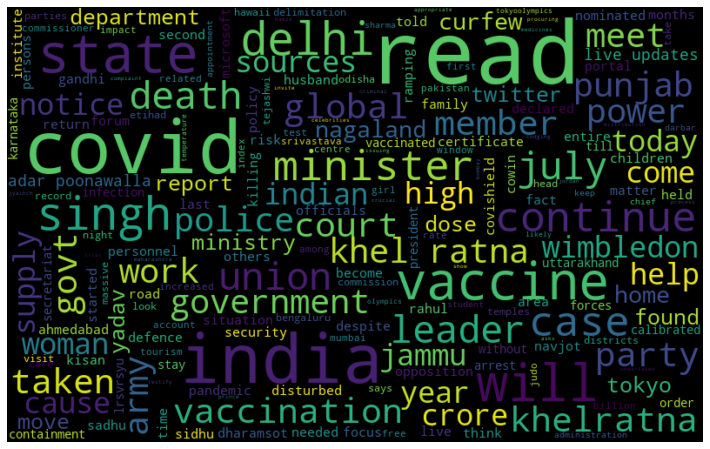

In [18]:
all_words=" ".join([sentence for sentence in df['Clean_Tweet']])
graph(all_words)

# 4) instantiate model

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch 

In [20]:
tokenizer=AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [21]:
def sentiment_score(tweets):
    tokens=tokenizer.encode(tweets,return_tensors='pt')
    result=model(tokens)
    return int(torch.argmax(result.logits))+1

In [22]:
df_new['Sentiment']=df['Clean_Tweet'].apply(lambda x: sentiment_score(x[:512]))  

In [23]:
df_new

,id,Tweet,Clean_Tweet,Sentiment
0,1,defence in jordan trial asks court to invite p...,defence jordan trial asks court invite prince ...,1
1,2,maharashtra govt had told bombay high court th...,maharashtra govt told bombay high court that a...,1
2,3,rt @toiplus: why man with 12 death sentences t...,with death sentences thinks will escape hangin...,1
3,4,dwarka honour killing case: cousin of woman he...,dwarka honour killing case cousin woman held s...,1
4,5,#wimbledon #svitolina \n\n@elinasvitolina batt...,wimbledon svitolina battles past opener read g...,5
...,...,...,...,...
95,96,today's temperature in delhi is likely to stay...,today temperature delhi likely stay above degr...,2
96,97,"pakistan under 'pressure' from us, western pow...",pakistan under pressure from western powers ov...,1
97,98,centre tells states it is critical that liftin...,centre tells states critical that lifting rest...,4
98,99,twitter has a zero-tolerance policy for child ...,twitter zero tolerance policy child sexual exp...,1


In [24]:
df_new['Clean_Tweet'].iloc[98]

'twitter zero tolerance policy child sexual exploitation will continue invest proactive detection removal content that violates twitter rules work with enforcement partners india tackle issue twitter spokesperson'

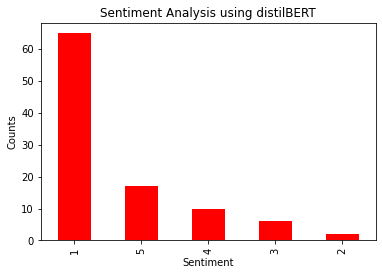

1    65
5    17
4    10
3     6
2     2
Name: Sentiment, dtype: int64


In [42]:
df_new['Sentiment'].value_counts()
plt.title('Sentiment Analysis using distilBERT')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_new['Sentiment'].value_counts().plot(kind='bar',color='red')
plt.show()
a=df_new['Sentiment'].value_counts()
print(a)

# 5) instantiate model distil bert

In [25]:
from transformers import DistilBertTokenizer, DistilBertModel

In [26]:
tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
def sentiment_score(tweets):
    encoded_input = tokenizer(tweets, return_tensors='pt')
    result = model(**encoded_input)
    return int(torch.argmax(result.logits))+1

In [28]:
df_new['Sentiment1']=df['Clean_Tweet'].apply(lambda x: sentiment_score(x[:512]))  
df_new

,id,Tweet,Clean_Tweet,Sentiment,Sentiment1
0,1,defence in jordan trial asks court to invite p...,defence jordan trial asks court invite prince ...,1,1
1,2,maharashtra govt had told bombay high court th...,maharashtra govt told bombay high court that a...,1,1
2,3,rt @toiplus: why man with 12 death sentences t...,with death sentences thinks will escape hangin...,1,1
3,4,dwarka honour killing case: cousin of woman he...,dwarka honour killing case cousin woman held s...,1,1
4,5,#wimbledon #svitolina \n\n@elinasvitolina batt...,wimbledon svitolina battles past opener read g...,5,5
...,...,...,...,...,...
95,96,today's temperature in delhi is likely to stay...,today temperature delhi likely stay above degr...,2,2
96,97,"pakistan under 'pressure' from us, western pow...",pakistan under pressure from western powers ov...,1,1
97,98,centre tells states it is critical that liftin...,centre tells states critical that lifting rest...,4,4
98,99,twitter has a zero-tolerance policy for child ...,twitter zero tolerance policy child sexual exp...,1,1


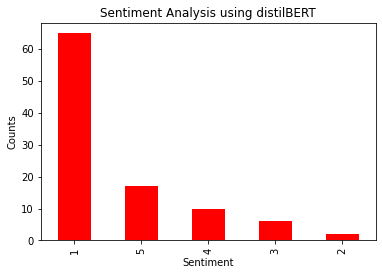

1    65
5    17
4    10
3     6
2     2
Name: Sentiment1, dtype: int64


In [41]:
df_new['Sentiment1'].value_counts()
plt.title('Sentiment Analysis using distilBERT')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_new['Sentiment1'].value_counts().plot(kind='bar',color='red')
plt.show()
a=df_new['Sentiment1'].value_counts()
print(a)